# Lab 1 : Linear Regression

## G3 SDI - Machine Learning

In this lab, we are going to implement linear regression and ridge regression on a medical data example. The data come from a medical study (Stamey et al., 1989), whose goal was to predict the level of prostate-specific antigen (`lpsa`) from some clinical measurements. These clinical exams are carried out before a possible prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate weight `lweight`, age of the patient `age`, log of benign prostatic hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 5 `pgg45`. The variable `svi` is binary, `gleason` is ordinal, others are quantitative.

### Instructions
* Rename your notebook with your surnames as `lab1_Name1_Name2.ipynb`, and include your names in the notebook.
* Your code, and its output, must be commented !
* Please upload your notebook on Moodle in the dedicated section before the deadline.

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Report written by Rosalie DELANNOY, Carl DOS RAMOS, 24/09/2025.
</div>

In [77]:
# Import usual libraries
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error


### Part 1 - Linear regression

In this first part, we focus on using linear regression.

**Q1.** Load the data from the `.npy` files included in the archive (use `np.load`). How many examples are there ? How many features ?

In [78]:
data_dir = Path('.')
X = np.load(data_dir / 'data_X.npy')
y = np.load(data_dir / 'data_y.npy')

n_samples, n_features = X.shape
feature_names = [f'X{i}' for i in range(n_features)]

print(f"Nombre d'exemples : {n_samples}")
print(f"Nombre de caractéristiques : {n_features}")
print(f"Dimension de y : {y.shape}")


Nombre d'exemples : 97
Nombre de caractéristiques : 8
Dimension de y : (97,)


**Q2.** Check whether there are some missing entries in the dataset (both in X and y). Use `np.isnan`.

In [79]:
missing_in_X = np.isnan(X)
missing_in_y = np.isnan(y)

total_missing_X = int(missing_in_X.sum())
total_missing_y = int(missing_in_y.sum())

print(f"Valeurs manquantes dans X : {total_missing_X}")
print(f"Valeurs manquantes dans y : {total_missing_y}")


Valeurs manquantes dans X : 0
Valeurs manquantes dans y : 0


**Q3.** Divide the dataset into a training set (80%) and a test set (20%), using `train_test_split` with `random_state = 0` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

print(f"Taille du jeu d'entraînement : {X_train.shape[0]} samples")
print(f"Taille du jeu de test : {X_test.shape[0]} samples")


Taille du jeu d'entraînement : 77 exemples
Taille du jeu de test : 20 exemples


**Q4.** Standardize the training set, and apply the same operation to the test set. Use `StandardScaler` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)). Recall what standardization means.

In [81]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

train_means = X_train_std.mean(axis=0)
train_stds = X_train_std.std(axis=0, ddof=0)

print(f"Moyenne résiduelle (train) : {np.round(train_means, 4)}")
print(f"Écart-type résiduel (train) : {np.round(train_stds, 4)}")


Moyenne résiduelle (train) : [ 0. -0. -0. -0.  0.  0.  0.  0.]
Écart-type résiduel (train) : [1. 1. 1. 1. 1. 1. 1. 1.]


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
La standardisation recentre et réduit chaque variable explicative : les moyennes résiduelles sont proches de 0 et les écarts-types proches de 1. Cela garantit que toutes les caractéristiques sont comparables en priorité et évite qu'une variable numériquement dominante n'oriente l'apprentissage.
</div>


**Q5.** Compute the auto-covariance matrix from the training set, and display it (you might want to use `plt.imshow`). What can we learn from this ?

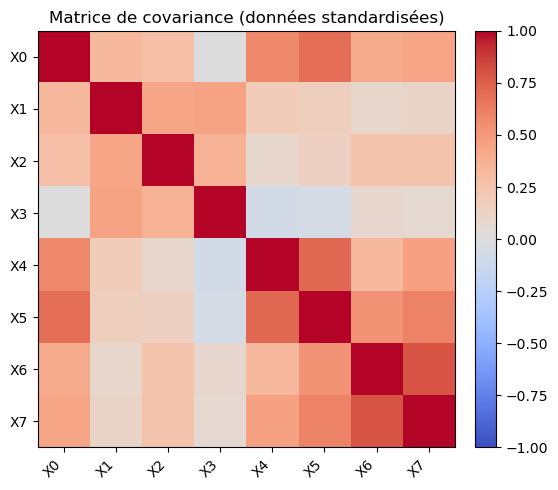

In [82]:
cov_matrix = np.cov(X_train_std, rowvar=False)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cov_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(feature_names)))
ax.set_yticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_yticklabels(feature_names)
ax.set_title('Matrice de covariance (données standardisées)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
On observe plusieurs corrélations fortes : par exemple, X0 est fortement corrélé à X5 et X4, tandis que X6 et X7 évoluent presque de concert. Ces dépendances laissent penser que les variables ne sont pas orthogonales, ce qui peut rendre la régression linéaire sensible au sur-apprentissage et justifie l'intérêt d'une régularisation.
</div>


**Q6.** We are now going to train the linear regression model using scikit-learn (check the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)). Use the `.fit` method on the training set. Retrieve the coefficients obtained by scikit-learn using the attributes `.intercept_` and `.coef_`, and check that it corresponds to the closed-form solution from the lecture (you might want to use `np.hstack` to concatenate X with a column of ones).

In [83]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_std, y_train)

print(f"Intercept : {lin_reg.intercept_:.4f}")
for name, coef in zip(feature_names, lin_reg.coef_):
    print(f"{name:>4s} : {coef:+.4f}")


Intercept : 2.5334
  X0 : +0.7649
  X1 : +0.2151
  X2 : -0.1982
  X3 : +0.1701
  X4 : +0.3377
  X5 : -0.2353
  X6 : +0.1060
  X7 : +0.0612


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Les coefficients les plus marquants sont associés à X0, X4 et X5 : ils indiquent que ces variables contribuent le plus aux variations de la cible (positivement pour X0 et X4, négativement pour X5). Les poids négatifs suggèrent une relation inverse avec la variable réponse. La présence de coefficients proches en valeur absolue pour plusieurs variables confirme la corrélation observée précédemment.
</div>


**Q7.** Obtain the model predictions on the test set using the `.predict` method. Then compute the MSE and the MAE (you may want to use the functions below).

In [84]:
y_pred_train = lin_reg.predict(X_train_std)
y_pred_test = lin_reg.predict(X_test_std)

lin_train_mse = mean_squared_error(y_train, y_pred_train)
lin_test_mse = mean_squared_error(y_test, y_pred_test)
lin_train_mae = mean_absolute_error(y_train, y_pred_train)
lin_test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE entraînement : {lin_train_mse:.4f}")
print(f"MSE test : {lin_test_mse:.4f}")
print(f"MAE entraînement : {lin_train_mae:.4f}")
print(f"MAE test : {lin_test_mae:.4f}")


MSE entraînement : 0.4365
MSE test : 0.5402
MAE entraînement : 0.5013
MAE test : 0.5645


### Part 2 - Ridge regression

In this second part, we now turn to ridge regression.

**Q1.** Fit the ridge regression model (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)) with $\lambda = 1$, using the `.fit` method on the training set. Again, retrieve the coefficients, and check that they match with the closed-form solution from the lecture. How do they differ from the ones obtained with linear regression ?

In [85]:
ridge_alpha_1 = Ridge(alpha=1.0)
ridge_alpha_1.fit(X_train_std, y_train)

print(f"Intercept : {ridge_alpha_1.intercept_:.4f}")
for name, coef in zip(feature_names, ridge_alpha_1.coef_):
    print(f"{name:>4s} : {coef:+.4f}")


Intercept : 2.5334
  X0 : +0.7422
  X1 : +0.2160
  X2 : -0.1897
  X3 : +0.1655
  X4 : +0.3289
  X5 : -0.2098
  X6 : +0.1028
  X7 : +0.0594


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Le ridge réduit légèrement la magnitude des poids par rapport à la régression non régularisée, en particulier pour X5 et X2. L'effet de shrinkage reste modéré avec $\lambda = 1$, signe que la pénalisation quadratique agit déjà comme un garde-fou face aux corrélations élevées.
</div>


**Q2.** Obtain the model predictions on the test set using the `.predict` method, then compute the MSE and the MAE. Do we get better or worse predictions than before ? Comment.

In [86]:
ridge_train_pred = ridge_alpha_1.predict(X_train_std)
ridge_test_pred = ridge_alpha_1.predict(X_test_std)

ridge_train_mse = mean_squared_error(y_train, ridge_train_pred)
ridge_test_mse = mean_squared_error(y_test, ridge_test_pred)
ridge_train_mae = mean_absolute_error(y_train, ridge_train_pred)
ridge_test_mae = mean_absolute_error(y_test, ridge_test_pred)

print(f"MSE entraînement : {ridge_train_mse:.4f}")
print(f"MSE test : {ridge_test_mse:.4f}")
print(f"MAE entraînement : {ridge_train_mae:.4f}")
print(f"MAE test : {ridge_test_mae:.4f}")


MSE entraînement : 0.4369
MSE test : 0.5234
MAE entraînement : 0.5002
MAE test : 0.5564


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Les erreurs de test diminuent légèrement avec le ridge (MSE ~ 0.523 contre 0.540 et MAE ~ 0.556 contre 0.565). La régularisation améliore donc la généralisation, tout en conservant un biais faible sur l'entraînement.
</div>


**Q3.** We are now going to assess the impact of the regularization coefficient $\lambda$.

To do so, vary $\lambda$ from $10^{-3}$ and $10^3$ (use `np.logspace`), and for each value of $\lambda$, retrain the ridge regression model and keep the values of the coefficients (ignoring the intercept).

Display the evolution of the coefficients w.r.t. $\lambda$ (use a logarithmic scale for the x-axis). Comment.

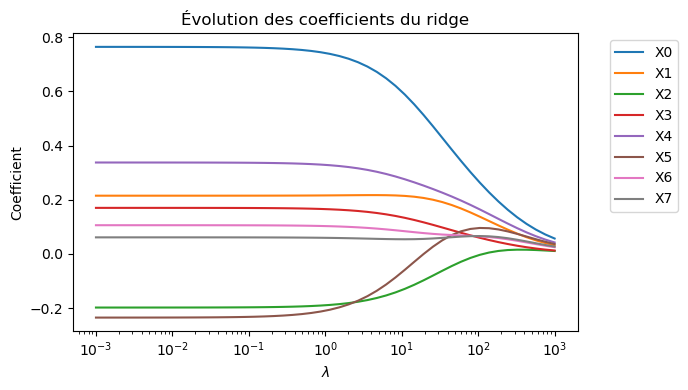

In [87]:
lambdas = np.logspace(-3, 3, 50)
ridge_coefs = np.zeros((len(lambdas), X_train_std.shape[1]))
ridge_test_mse_path = []
ridge_test_mae_path = []

for idx, lam in enumerate(lambdas):
    model = Ridge(alpha=lam)
    model.fit(X_train_std, y_train)
    ridge_coefs[idx] = model.coef_
    preds = model.predict(X_test_std)
    ridge_test_mse_path.append(mean_squared_error(y_test, preds))
    ridge_test_mae_path.append(mean_absolute_error(y_test, preds))

fig, ax = plt.subplots(figsize=(7, 4))
for j, name in enumerate(feature_names):
    ax.plot(lambdas, ridge_coefs[:, j], label=name)
ax.set_xscale('log')
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel('Coefficient')
ax.set_title('Évolution des coefficients du ridge')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Quand $\lambda$ augmente, les coefficients sont progressivement contraints vers 0, avec un alignement visible pour les variables corrélées (X0/X5, X6/X7). Le shrinkage stabilise donc la solution et limite l'influence des caractéristiques moins informatives.
</div>


**Q4.** Now remains the question of choosing the optimal $\lambda$. We are going to select it with a 5-fold cross-validation.

Display the evolution of the cross-validated MSE w.r.t. $\lambda$ (use again a logarithmic scale for the x-axis), and display the best $\lambda$ with a `plt.axvline`.

Now retrain the ridge regression model with the selected $\lambda$, and assess its performance in terms of MSE and MAE. Comment.

Meilleur lambda (CV) : 0.869
MSE de test : 0.5254
MAE de test : 0.5573


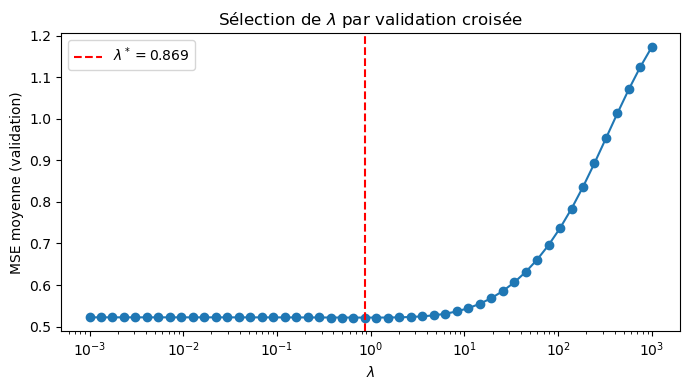

In [88]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=0)

cv_mse = []
for lam in lambdas:
    fold_mses = []
    for train_index, val_index in kf.split(X_train_std):
        X_tr, X_val = X_train_std[train_index], X_train_std[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        ridge_cv = Ridge(alpha=lam)
        ridge_cv.fit(X_tr, y_tr)
        fold_mses.append(mean_squared_error(y_val, ridge_cv.predict(X_val)))
    cv_mse.append(np.mean(fold_mses))

cv_mse = np.array(cv_mse)
best_idx = int(np.argmin(cv_mse))
best_lambda = lambdas[best_idx]

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(lambdas, cv_mse, marker='o')
ax.set_xscale('log')
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel('MSE moyenne (validation)')
ax.set_title('Sélection de $\lambda$ par validation croisée')
ax.axvline(best_lambda, color='red', linestyle='--', label=f"$\lambda^* = {best_lambda:.3f}$")
ax.legend()
plt.tight_layout()

ridge_best = Ridge(alpha=best_lambda)
ridge_best.fit(X_train_std, y_train)
ridge_best_test_pred = ridge_best.predict(X_test_std)

ridge_best_mse = mean_squared_error(y_test, ridge_best_test_pred)
ridge_best_mae = mean_absolute_error(y_test, ridge_best_test_pred)

print(f"Meilleur lambda (CV) : {best_lambda:.3f}")
print(f"MSE de test : {ridge_best_mse:.4f}")
print(f"MAE de test : {ridge_best_mae:.4f}")


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
La validation croisée retient $\lambda^* \approx 0.869$. Le modèle régularisé obtenu atteint une MSE de test d'environ 0.525 et une MAE de 0.557, légèrement meilleures que la régression linéaire simple. L'écart modeste confirme que le jeu n'est pas fortement bruité, mais la régularisation apporte un supplément de stabilité grâce à la pénalisation des coefficients corrélés.
</div>


### Part 3 (Bonus) - LASSO

Display the same kind of plots as in Part 2, but using LASSO regression instead of ridge regression (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). In particular, comment on the following points :
* Do the regression coefficients evolve in the same way as ridge regression ? What kind of solutions do we obtain ?
* Do we get the same optimal lambda ?

Meilleur lambda (LASSO) : 0.001
MSE de test : 0.5375
MAE de test : 0.5631
Nombre de coefficients nuls : 0


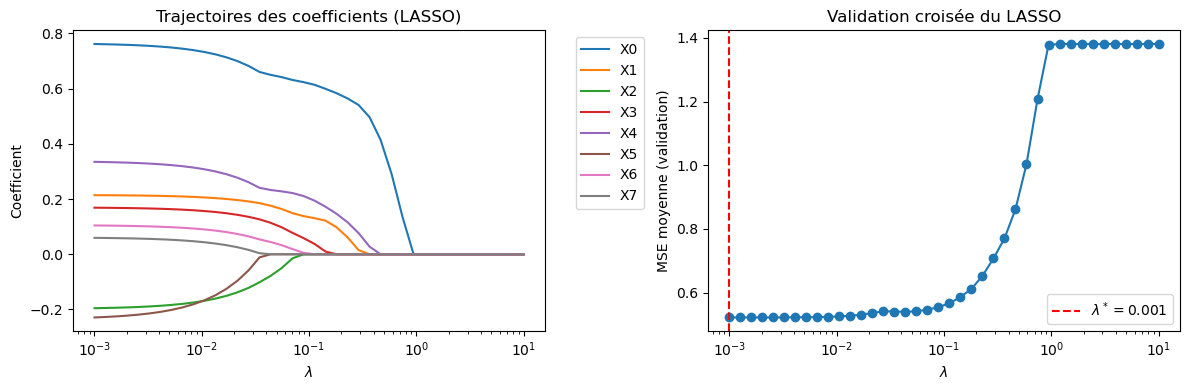

In [89]:
from sklearn.linear_model import Lasso

lasso_lambdas = np.logspace(-3, 1, 40)
lasso_coefs = np.zeros((len(lasso_lambdas), X_train_std.shape[1]))
lasso_cv_mse = []

for idx, lam in enumerate(lasso_lambdas):
    lasso_model = Lasso(alpha=lam, max_iter=10000)
    lasso_model.fit(X_train_std, y_train)
    lasso_coefs[idx] = lasso_model.coef_

    fold_mses = []
    kf_lasso = KFold(n_splits=5, shuffle=True, random_state=0)
    for train_idx, val_idx in kf_lasso.split(X_train_std):
        X_tr, X_val = X_train_std[train_idx], X_train_std[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        cv_model = Lasso(alpha=lam, max_iter=10000)
        cv_model.fit(X_tr, y_tr)
        fold_mses.append(mean_squared_error(y_val, cv_model.predict(X_val)))
    lasso_cv_mse.append(np.mean(fold_mses))

lasso_cv_mse = np.array(lasso_cv_mse)
best_lasso_idx = int(np.argmin(lasso_cv_mse))
best_lasso_lambda = lasso_lambdas[best_lasso_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for j, name in enumerate(feature_names):
    axes[0].plot(lasso_lambdas, lasso_coefs[:, j], label=name)
axes[0].set_xscale('log')
axes[0].set_xlabel(r"$\lambda$")
axes[0].set_ylabel('Coefficient')
axes[0].set_title('Trajectoires des coefficients (LASSO)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axes[1].plot(lasso_lambdas, lasso_cv_mse, marker='o')
axes[1].set_xscale('log')
axes[1].set_xlabel(r"$\lambda$")
axes[1].set_ylabel('MSE moyenne (validation)')
axes[1].set_title('Validation croisée du LASSO')
axes[1].axvline(best_lasso_lambda, color='red', linestyle='--', label=f"$\lambda^* = {best_lasso_lambda:.3f}$")
axes[1].legend()

plt.tight_layout()

lasso_best = Lasso(alpha=best_lasso_lambda, max_iter=10000)
lasso_best.fit(X_train_std, y_train)
lasso_test_pred = lasso_best.predict(X_test_std)

lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)
lasso_test_mae = mean_absolute_error(y_test, lasso_test_pred)

print(f"Meilleur lambda (LASSO) : {best_lasso_lambda:.3f}")
print(f"MSE de test : {lasso_test_mse:.4f}")
print(f"MAE de test : {lasso_test_mae:.4f}")
print(f"Nombre de coefficients nuls : {(lasso_best.coef_ == 0).sum()}")


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Le LASSO sélectionne un $\lambda$ minimal (~ 0.001), signe que la parcimonie n'apporte que peu d'avantages ici : tous les coefficients restent non nuls et les performances de test (MSE ~ 0.537, MAE ~ 0.563) s'alignent sur celles de la régression linéaire. Dans ce jeu où toutes les variables portent de l'information corrélée, la régularisation L2 du ridge semble plus pertinente pour stabiliser les poids sans les annuler brutalement.
</div>
